In [8]:
import sys
print(sys.version)
import numpy as np
import tensorflow as tf
from time import gmtime, strftime
import time
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import model
import utils
import cv2
print(cv2.__version__)
from IPython import display
%matplotlib inline

3.5.3 |Continuum Analytics, Inc.| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]
3.1.0


In [9]:
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

config = type("Foo", (object,), {})()
config.dataset = 'celebA'
config.batch_size = 64

#with tf.Session(config=run_config) as sess:
sess = tf.Session(config=run_config) 
dcgan = model.DCGAN(
    sess,
    input_height=108,
    input_width=108,
    output_width=64,
    output_height=64,
    batch_size=config.batch_size,
    sample_num=64,
    dataset_name='celebA',
    input_fname_pattern='*.jpg',
    crop=True, #true for training
    checkpoint_dir='checkpoint',
    sample_dir='samples'
)

if not dcgan.load('checkpoint')[0]:
    print('Cannot find checkpoint!')

utils.show_all_variables()


 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint\celebA_64_64_64\DCGAN.model-32502
 [*] Success to read DCGAN.model-32502
---------
Variables: name (type shape) [size]
---------
generator/g_h0_lin/Matrix:0 (float32_ref 100x8192) [819200, bytes: 3276800]
generator/g_h0_lin/bias:0 (float32_ref 8192) [8192, bytes: 32768]
generator/g_bn0/beta:0 (float32_ref 512) [512, bytes: 2048]
generator/g_bn0/gamma:0 (float32_ref 512) [512, bytes: 2048]
generator/g_h1/w:0 (float32_ref 5x5x256x512) [3276800, bytes: 13107200]
generator/g_h1/biases:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/beta:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/gamma:0 (float32_ref 256) [256, bytes: 1024]
generator/g_h2/w:0 (float32_ref 5x5x128x256) [819200, bytes: 3276800]
generator/g_h2/biases:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/beta:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/gamma:0 (float32_ref 128) [128, bytes: 512]
generator/g_h3/w:0 (floa

In [10]:
def get_mask(file):
    image = imread(file)
    a = image[:,:,0]
    b = a/np.max(a)
    c = np.rint(b)
    return c

def deprocess_image(img):
    return np.clip(255 * (img+0.5), 0.0, 255.0).astype(np.uint8)


In [11]:
z_sample = np.random.uniform(-0.5, 0.5, size=(config.batch_size, dcgan.z_dim))

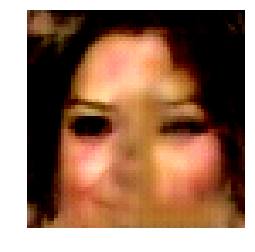

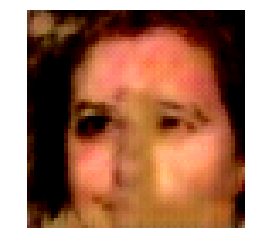

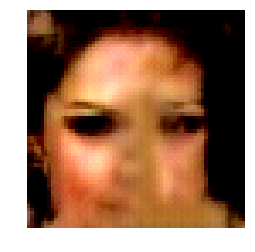

1497245237994


KeyboardInterrupt: 

In [18]:
z_mask = np.ones([dcgan.z_dim])
h0_mask = np.ones([int(dcgan.output_height/16), int(dcgan.output_width/16)]) # 4, 4
h1_mask = np.ones([int(dcgan.output_height/8), int(dcgan.output_width/8)]) # 8, 8
h2_mask = np.ones([int(dcgan.output_height/4), int(dcgan.output_width/4)]) # 16, 16
h3_mask = np.ones([int(dcgan.output_height/2), int(dcgan.output_width/2)]) # 32, 32
h4_mask = np.ones([int(dcgan.output_height), int(dcgan.output_width)]) # 64, 64

vc.release()
vc = cv2.VideoCapture(1)

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    if frame is not None:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    # makes the blues image look real colored
        webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False
    
print(is_capturing)
while is_capturing:
    try:    # Lookout for a keyboardInterrupt to stop the script
        is_capturing, frame = vc.read()
        if frame is not None:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    # makes the blues image look real colored
            #print(frame.shape) # (480, 640) * (1/15, 1/20) = (32, 32)
            #res = cv2.resize(frame, None, fx=1/20, fy=1/15, interpolation=cv2.INTER_AREA) # 32, 32
            #res = cv2.resize(frame, None, fx=1/40, fy=1/30, interpolation=cv2.INTER_AREA) # 16, 16
            res = cv2.resize(frame, None, fx=1/80, fy=1/60, interpolation=cv2.INTER_AREA) # 8, 8
            #print(res.shape)
            res_min = np.min(res)
            res_max = np.max(res)
            scaled = (res - res_min)/float(res_max - res_min)
            flipped = cv2.flip(scaled, 1)
            flipped[flipped>.5] = 1
            flipped[flipped<=.5] = 0
            h1_mask = flipped
            
            feed_dict = {
                dcgan.z: z_sample, 
                dcgan.z_mask: z_mask,
                dcgan.h0_mask: h0_mask,
                dcgan.h1_mask: h1_mask,
                dcgan.h2_mask: h2_mask,
                dcgan.h3_mask: h3_mask,
                dcgan.h4_mask: h4_mask,
            }
            print(int(round(time.time() * 1000)))
            samples = sess.run(dcgan.sampler, feed_dict=feed_dict)
            print(int(round(time.time() * 1000))) # about 60ms on gpu to run 
            #utils.save_images(samples, [8,8], './samples/test_%s.png' % strftime("%Y%m%d%H%M%S", gmtime()))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            for image in samples[:3]:
                plt.imshow(deprocess_image(image))
                plt.axis('off')
                plt.show()
            
            #webcam_preview = plt.imshow(flipped)
            #webcam_preview.set_data(flipped)
            #plt.draw()
            #break
            
    except KeyboardInterrupt:
        vc.release()




(64, 64, 64, 3)


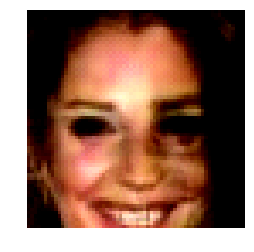

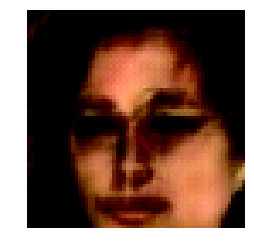

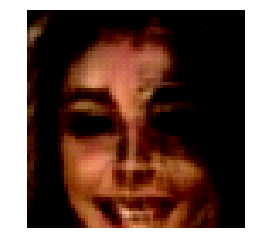

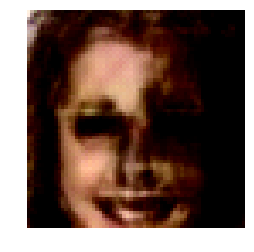

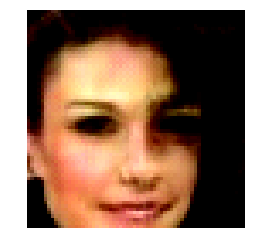

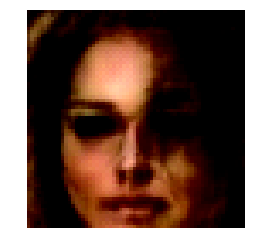

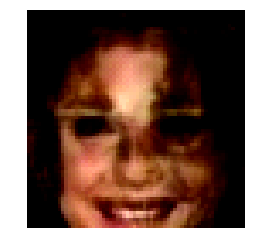

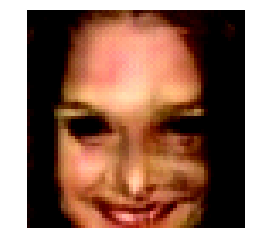

In [7]:
print(samples.shape)
for image in samples[:8]:
    plt.imshow(deprocess_image(image))
    plt.axis('off')
    plt.show()